<a href="https://colab.research.google.com/github/adamstra/MyModel/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

In [46]:
# Configurations
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = "/content/drive/MyDrive/data/train"

In [47]:
# Fonction pour charger et parser les fichiers XML
def parse_pascal_voc_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    labels = []
    for obj in root.findall("object"):
        label = obj.find("name").text
        labels.append(label)
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])
    return boxes, labels

In [48]:
# Fonction pour charger les images et les annotations
def load_data(data_dir):
    images = []
    annotations = []
    for file in os.listdir(data_dir):
        if file.endswith(".jpg"):
            img_path = os.path.join(data_dir, file)
            xml_path = os.path.join(data_dir, file.replace(".jpg", ".xml"))
            image = cv2.imread(img_path)
            image = cv2.resize(image, IMG_SIZE)
            images.append(image)
            boxes, labels = parse_pascal_voc_annotation(xml_path)
            annotations.append((boxes, labels))  # Stocker les annotations comme une liste de tuples
    return np.array(images), annotations  # Laisser annotations en tant que liste de tuples


In [49]:
# Charger les données
images, annotations = load_data(DATA_DIR)
images = images / 255.0  # Normalisation

In [50]:
# Extraire les labels des annotations
def extract_labels(annotations):
    labels = []
    for _, ann_labels in annotations:
        if ann_labels:  # S'il y a des labels dans l'image
            labels.append(ann_labels[0])  # Prendre le premier label pour simplifier la classification
        else:
            labels.append("NoObject")  # Label pour les images sans objets annotés
    return labels

In [51]:
# Encoder les labels
labels = extract_labels(annotations)
label_binarizer = LabelBinarizer()
encoded_labels = label_binarizer.fit_transform(labels)

In [32]:
# Diviser les données en entraînement et validation
train_images, val_images, train_labels, val_labels = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)


In [52]:
# Générateur d'augmentation de données
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, fill_mode="nearest")


In [53]:
# Ensure the generator fits the images
datagen.fit(train_images)

In [54]:
# Modèle CNN simple pour la classification
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(*IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(len(label_binarizer.classes_), activation="softmax")  # Le nombre de classes pour la classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │           1,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,699,984 (6.48 MB)

 Trainable params: 1,699,984 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Compilation du modèle
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [57]:
# Entraînement du modèle
history = model.fit(datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE), epochs=EPOCHS, validation_data=(val_images, val_labels))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2511 - loss: 2.3937 - val_accuracy: 0.2796 - val_loss: 2.2604
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2868 - loss: 2.2377 - val_accuracy: 0.2796 - val_loss: 2.3032
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3038 - loss: 2.1910 - val_accuracy: 0.2844 - val_loss: 2.2424
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2983 - loss: 2.1687 - val_accuracy: 0.2891 - val_loss: 2.2059
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2825 - loss: 2.1686 - val_accuracy: 0.2654 - val_loss: 2.1866
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3001 - loss: 2.1351 - val_accuracy: 0.2417 - val_loss: 2.1983
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2784 - loss: 2.1778 - val_accuracy: 0.2938 - val_loss: 2.1894
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3021 - loss: 2.1347 - val_accuracy: 0.2938 - val_loss: 2.2126
Epo

In [58]:
# Afficher les classes
print("Classes:", label_binarizer.classes_)

Classes: ['arret tata' 'bus' 'bus dem dikk' 'bus tata' 'camion' 'car rapide'
 'charette' 'feu' 'fourgon' 'moto' 'moto tricycle' 'ndiaga ndiaye'
 'particulier' 'person' 'pousse pousse' 'taxi']


In [59]:
# Évaluation et métriques
val_preds = model.predict(val_images)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 459ms/step


In [60]:
val_preds

array([[2.4660584e-04, 3.5263938e-03, 1.1026667e-03, ..., 6.2573396e-02,
        2.8848859e-02, 2.2348741e-02],
       [2.7462933e-03, 3.1284150e-03, 4.7403593e-03, ..., 1.3801298e-01,
        1.3247263e-02, 3.7010025e-02],
       [3.2795917e-03, 1.4969270e-03, 4.8732907e-03, ..., 1.7481934e-01,
        1.5167466e-02, 2.4335615e-01],
       ...,
       [7.7143451e-03, 3.6627152e-03, 1.9572726e-03, ..., 3.1916288e-01,
        2.0769512e-02, 6.1982352e-02],
       [6.1883633e-03, 3.9234054e-03, 1.6803177e-03, ..., 2.3627847e-01,
        2.4057122e-02, 5.7935968e-02],
       [6.3614389e-03, 3.8950292e-03, 3.6351485e-04, ..., 2.5362778e-01,
        5.3091928e-02, 9.7914562e-03]], dtype=float32)

In [68]:
# prompt: afficher le score

# Évaluation et métriques
val_loss, val_accuracy = model.evaluate(val_images, val_labels)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)

# Afficher le rapport de classification
y_pred = np.argmax(val_preds, axis=1)
y_true = np.argmax(val_labels, axis=1)

# Get unique classes in predictions and true labels
unique_classes_pred = np.unique(y_pred)
unique_classes_true = np.unique(y_true)

# Find the missing class (if any)
missing_class = list(set(unique_classes_true) - set(unique_classes_pred))

# Print or investigate the missing class
print("Missing class in predictions:", missing_class)

# Instead of truncating target_names, provide 'labels' argument
print(classification_report(y_true, y_pred, labels=np.arange(len(label_binarizer.classes_)), target_names=label_binarizer.classes_))


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step - accuracy: 0.2276 - loss: 2.4453
Val Loss: 2.3694610595703125
Val Accuracy: 0.24644549190998077
Missing class in predictions: [0, 2, 4, 7, 8, 10, 14]
               precision    recall  f1-score   support

   arret tata       0.00      0.00      0.00         3
          bus       0.00      0.00      0.00         0
 bus dem dikk       0.00      0.00      0.00         3
     bus tata       0.17      0.06      0.09        16
       camion       0.00      0.00      0.00         5
   car rapide       0.00      0.00      0.00         7
     charette       0.07      0.12      0.09         8
          feu       0.00      0.00      0.00         1
      fourgon       0.00      0.00      0.00         5
         moto       0.00      0.00      0.00        17
moto tricycle       0.00      0.00      0.00         6
ndiaga ndiaye       0.00      0.00      0.00         4
  particulier       0.35      0.46      0.40        59
       person       0.22      0.45     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

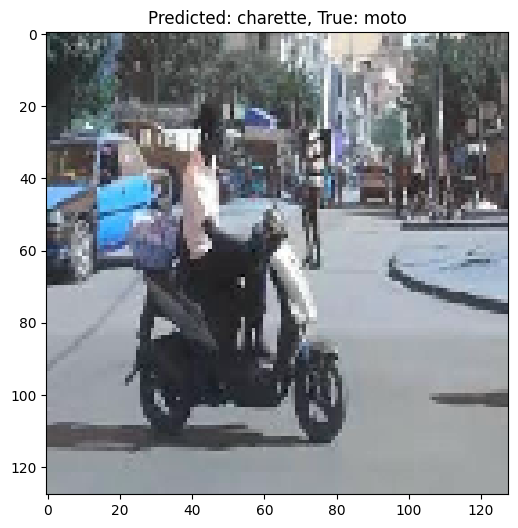

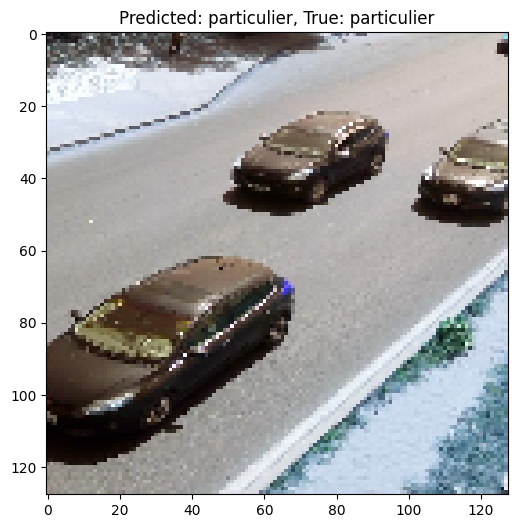

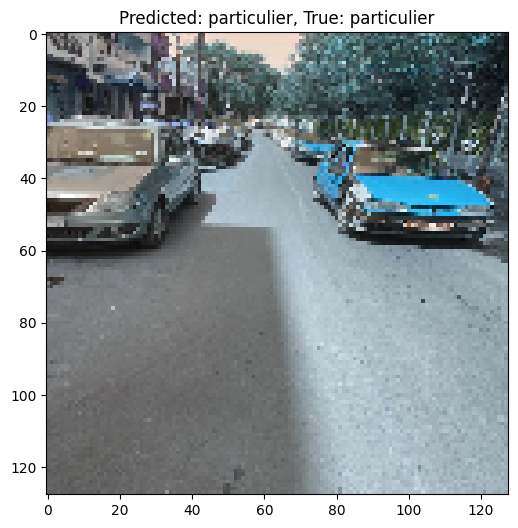

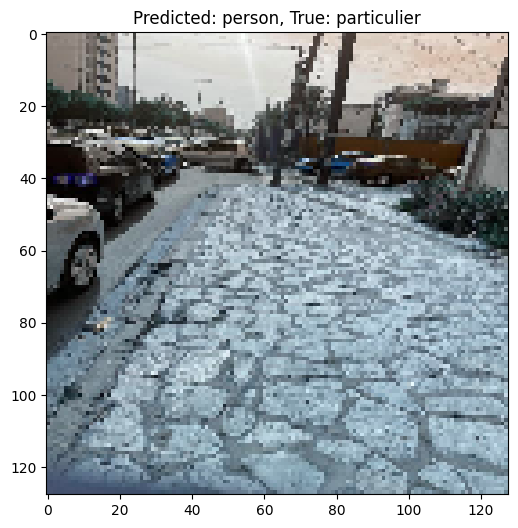

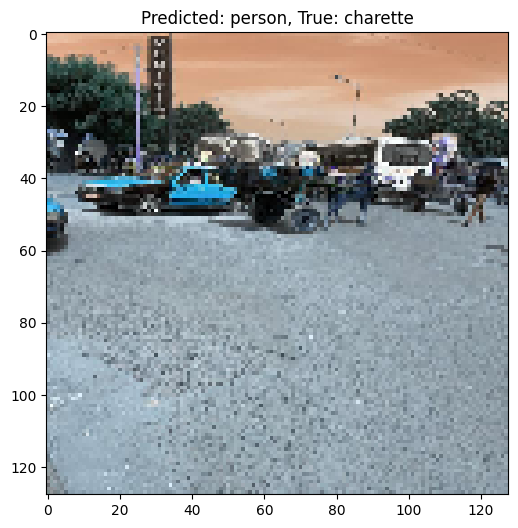

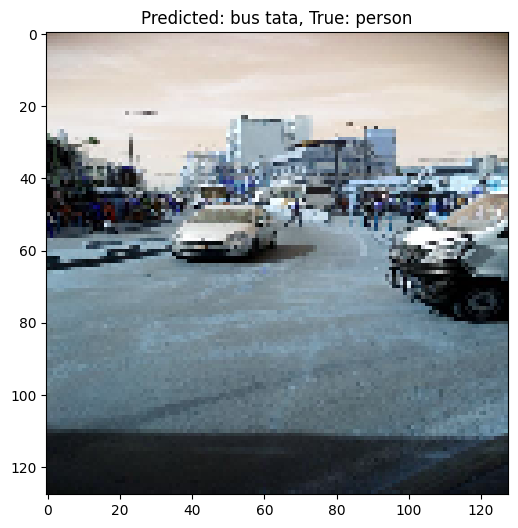

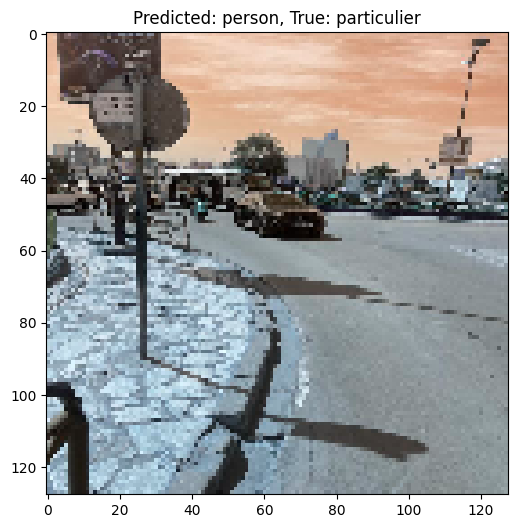

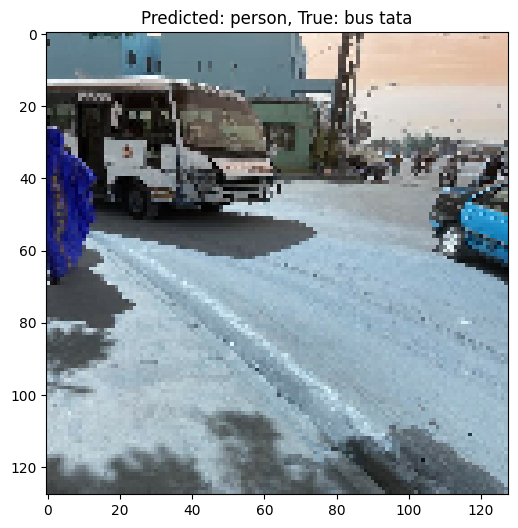

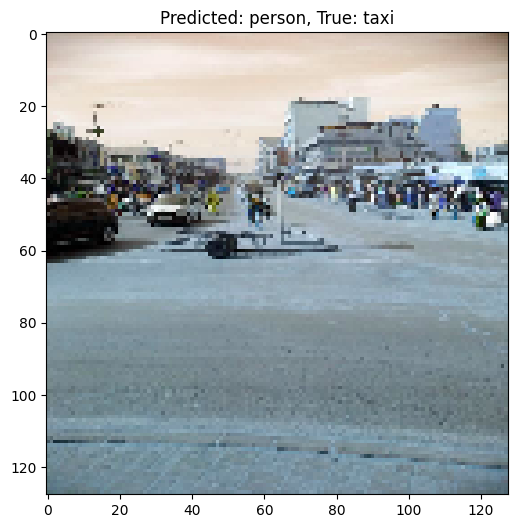

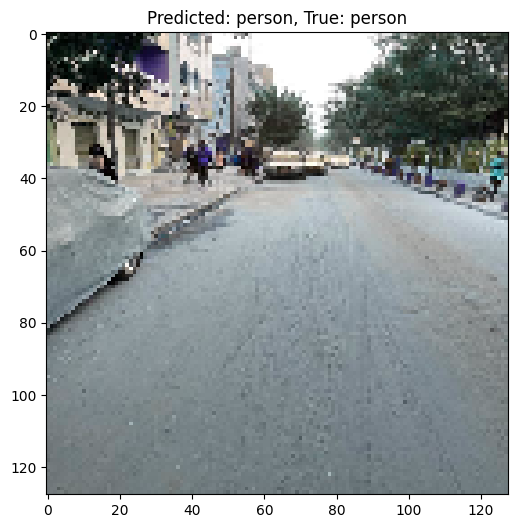

In [75]:
# prompt: afficher les images de validation

import matplotlib.pyplot as plt

# Affichez quelques images de validation avec leurs labels prédits
for i in range(10):  # Affichez 10 images de validation
  plt.figure(figsize=(6, 6))
  plt.imshow(val_images[i])
  predicted_label = label_binarizer.classes_[np.argmax(val_preds[i])]
  true_label = label_binarizer.classes_[np.argmax(val_labels[i])]
  plt.title(f"Predicted: {predicted_label}, True: {true_label}")
  plt.show()